### Comparing CHAOS80 to full CHAOS model.

Using local model calculation. Comparing different missions.

In [1]:
from viresclient._wps.time_util import parse_datetime, parse_duration
from validation import get_random_time, get_random_collection, get_data, get_collection_date_range

SERVER_URL = "https://staging.viresdisc.vires.services"

COLLECTIONS = {
    "Swarm": ["SW_OPER_MAGA_LR_1B", "SW_OPER_MAGB_LR_1B", "SW_OPER_MAGC_LR_1B"],
    "GOCE": ["GO_MAG_ACAL_CORR", "GO_MAG_ACAL_CORR_ML"],
    "CryoSat-2": ["CS_OPER_MAG"],
    "GRACE-FO": ["GF1_OPER_FGM_ACAL_CORR", "GF2_OPER_FGM_ACAL_CORR"],
    "GRACE": ["GRACE_A_MAG", "GRACE_B_MAG"],
}

SELECTION_TIME = "P365D"
#SELECTION_TIME = "P1D"

OPTIONS = {
    "models": [
        "CHAOS80 = 'CHAOS-Core' + 'CHAOS-Static'(max_degree=80) + 'CHAOS-MMA'",
        "CHAOS = 'CHAOS-Core' + 'CHAOS-Static' + 'CHAOS-MMA'",
    ]
}


def _get_data(url, collections, selection_time, **extra_options):
    selection_time = parse_duration(selection_time)
    collection = get_random_collection(collections)
    collection_start_time, collection_end_time = get_collection_date_range(url, collection)
    start_time = get_random_time(
        collection_start_time,
        collection_end_time - selection_time
    )
    end_time = start_time + selection_time
    options = {
        "url": url,
        "collection": collection,
        "start_time": start_time,
        "end_time": end_time,
    }
    return {
        "options": {**options, **extra_options},
        "data": get_data(**options, **extra_options),
    }


data = {}
for mission, collections in COLLECTIONS.items():
    data[mission] = _get_data(SERVER_URL, collections, SELECTION_TIME, **OPTIONS)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (55.312MB)

https://staging.viresdisc.vires.services 106.84s


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (48.01MB)

https://staging.viresdisc.vires.services 57.4706s


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (55.303MB)

https://staging.viresdisc.vires.services 87.5635s


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (55.284MB)

https://staging.viresdisc.vires.services 103.825s


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (53.839MB)

https://staging.viresdisc.vires.services 110.251s


/opt/conda/lib/python3.9/site-packages/spacepy/time.py:2365: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


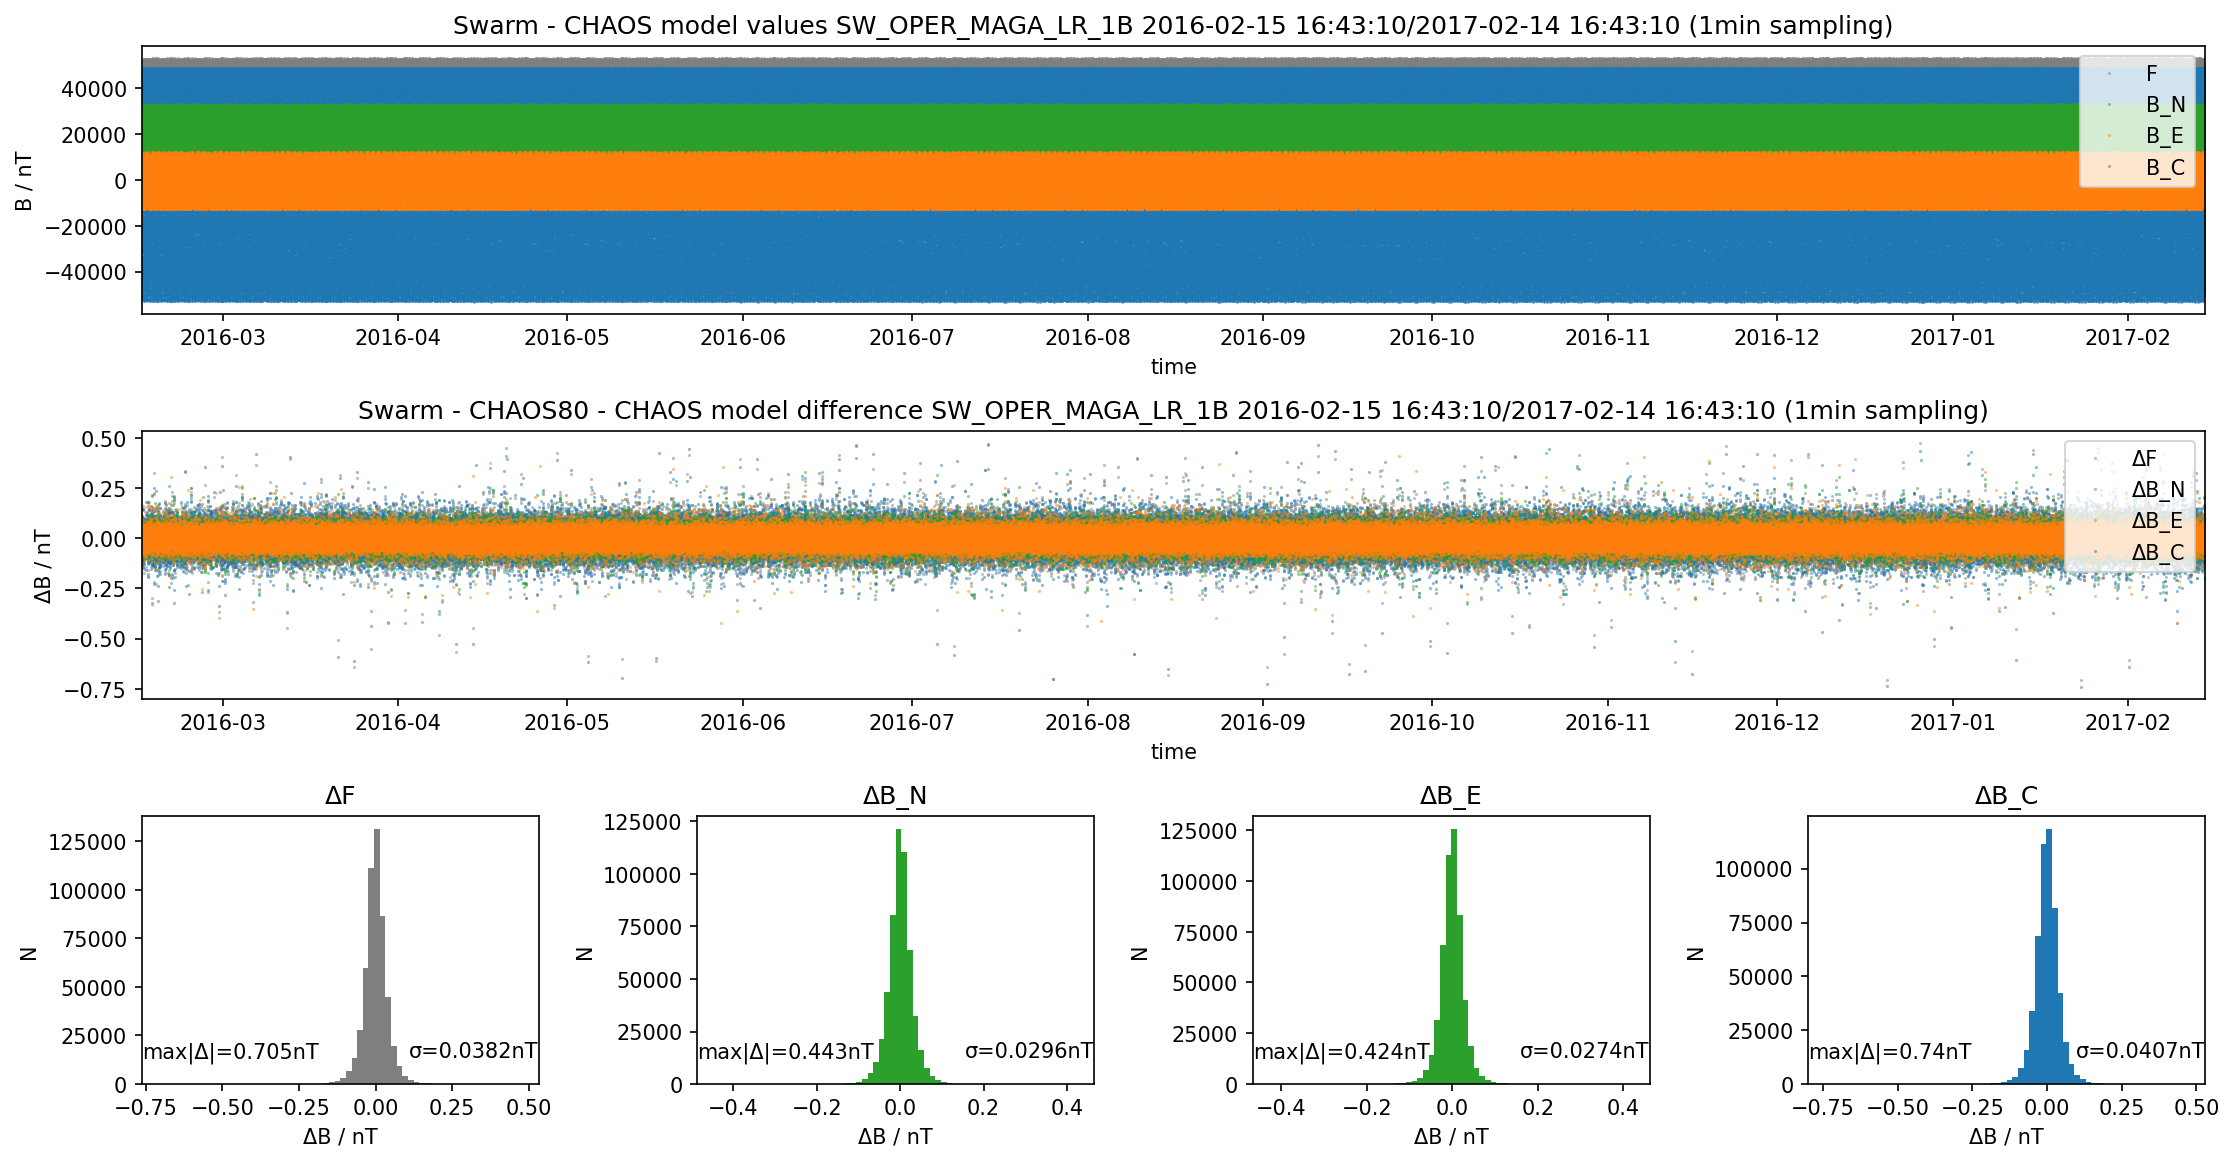

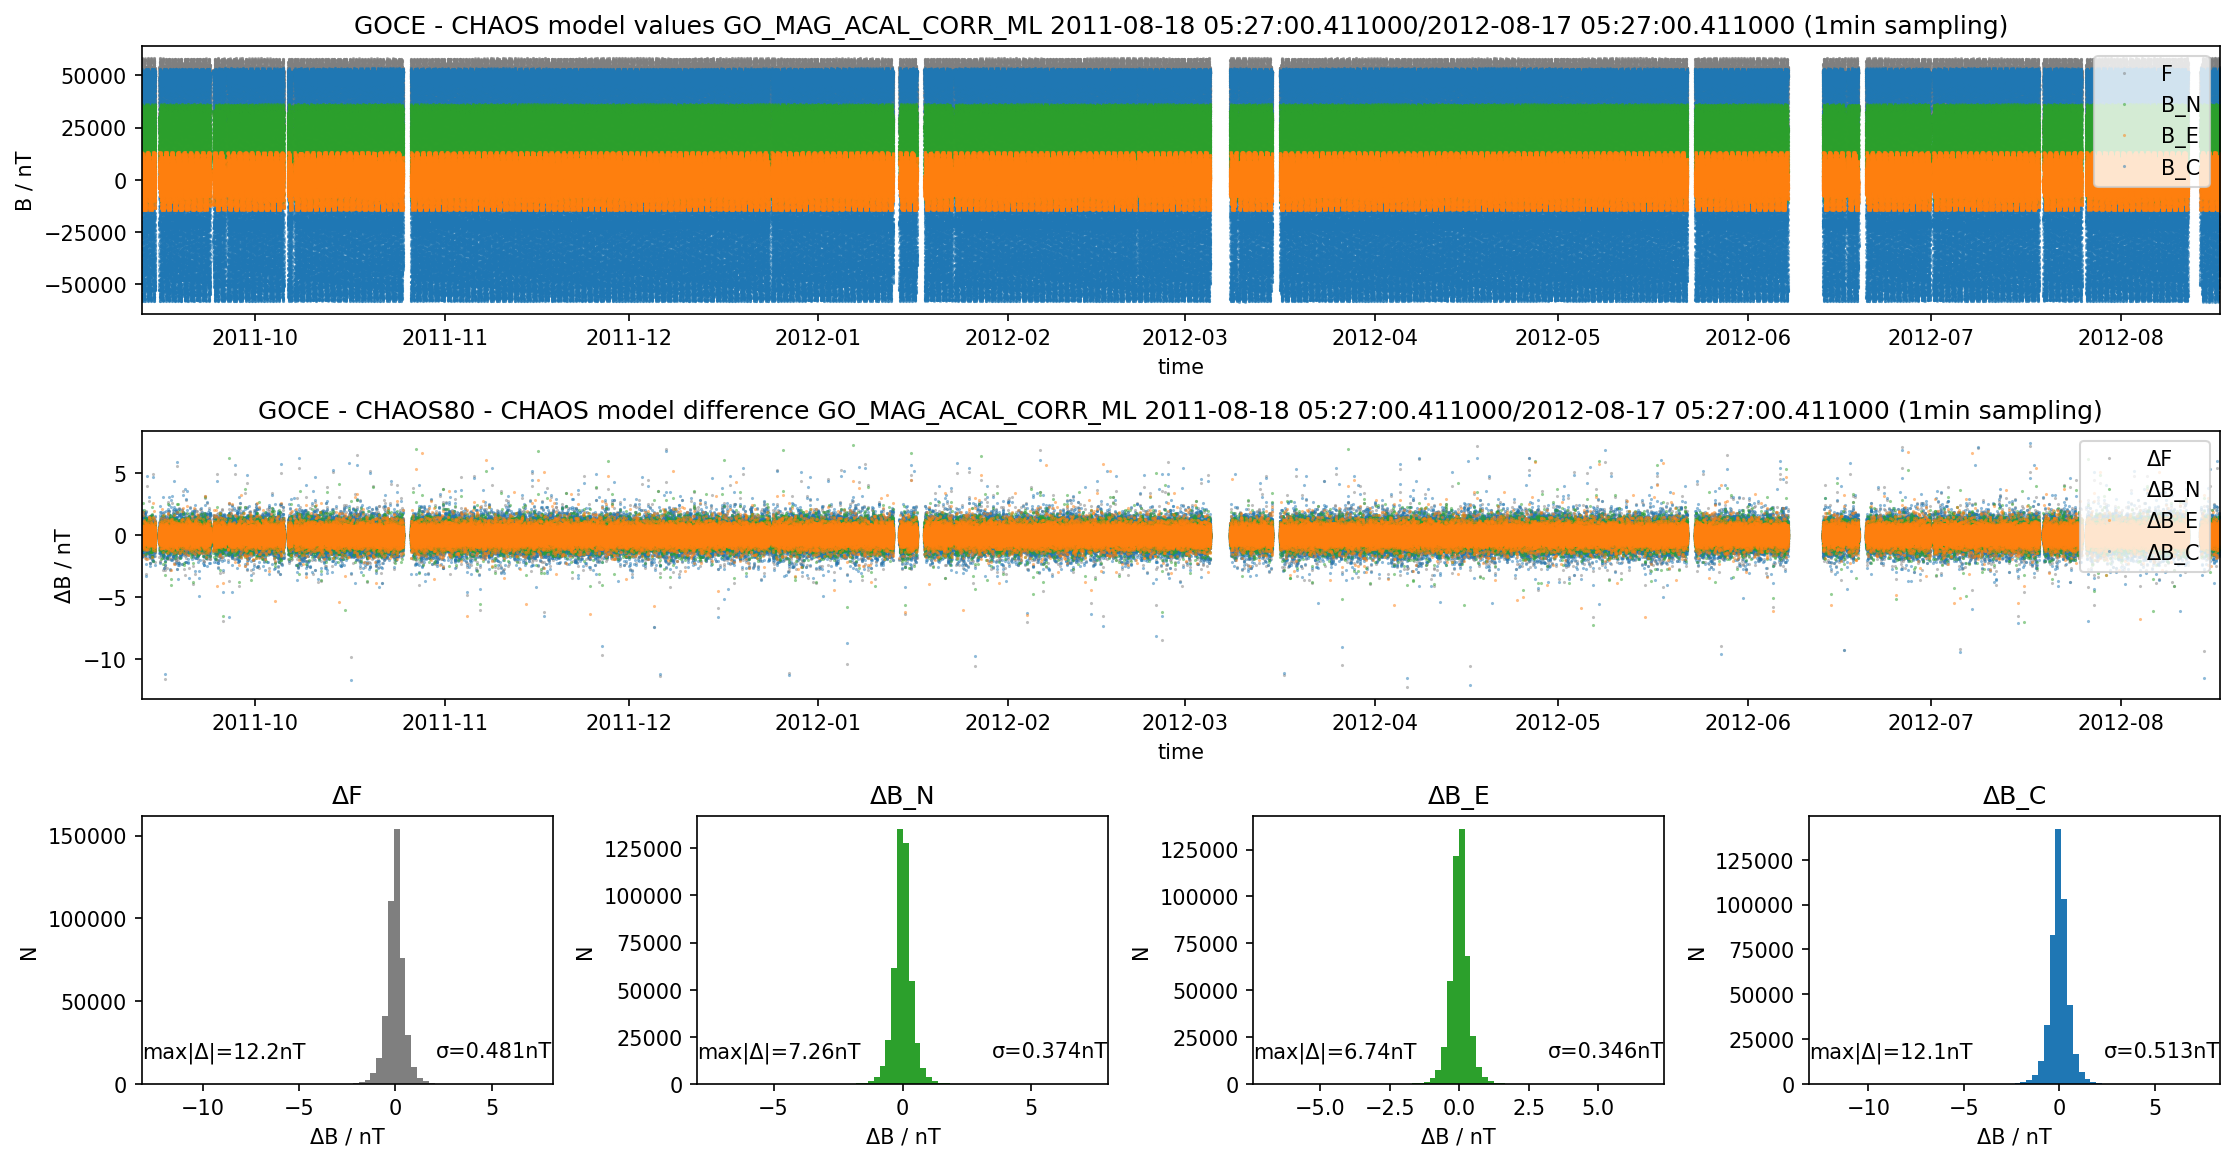

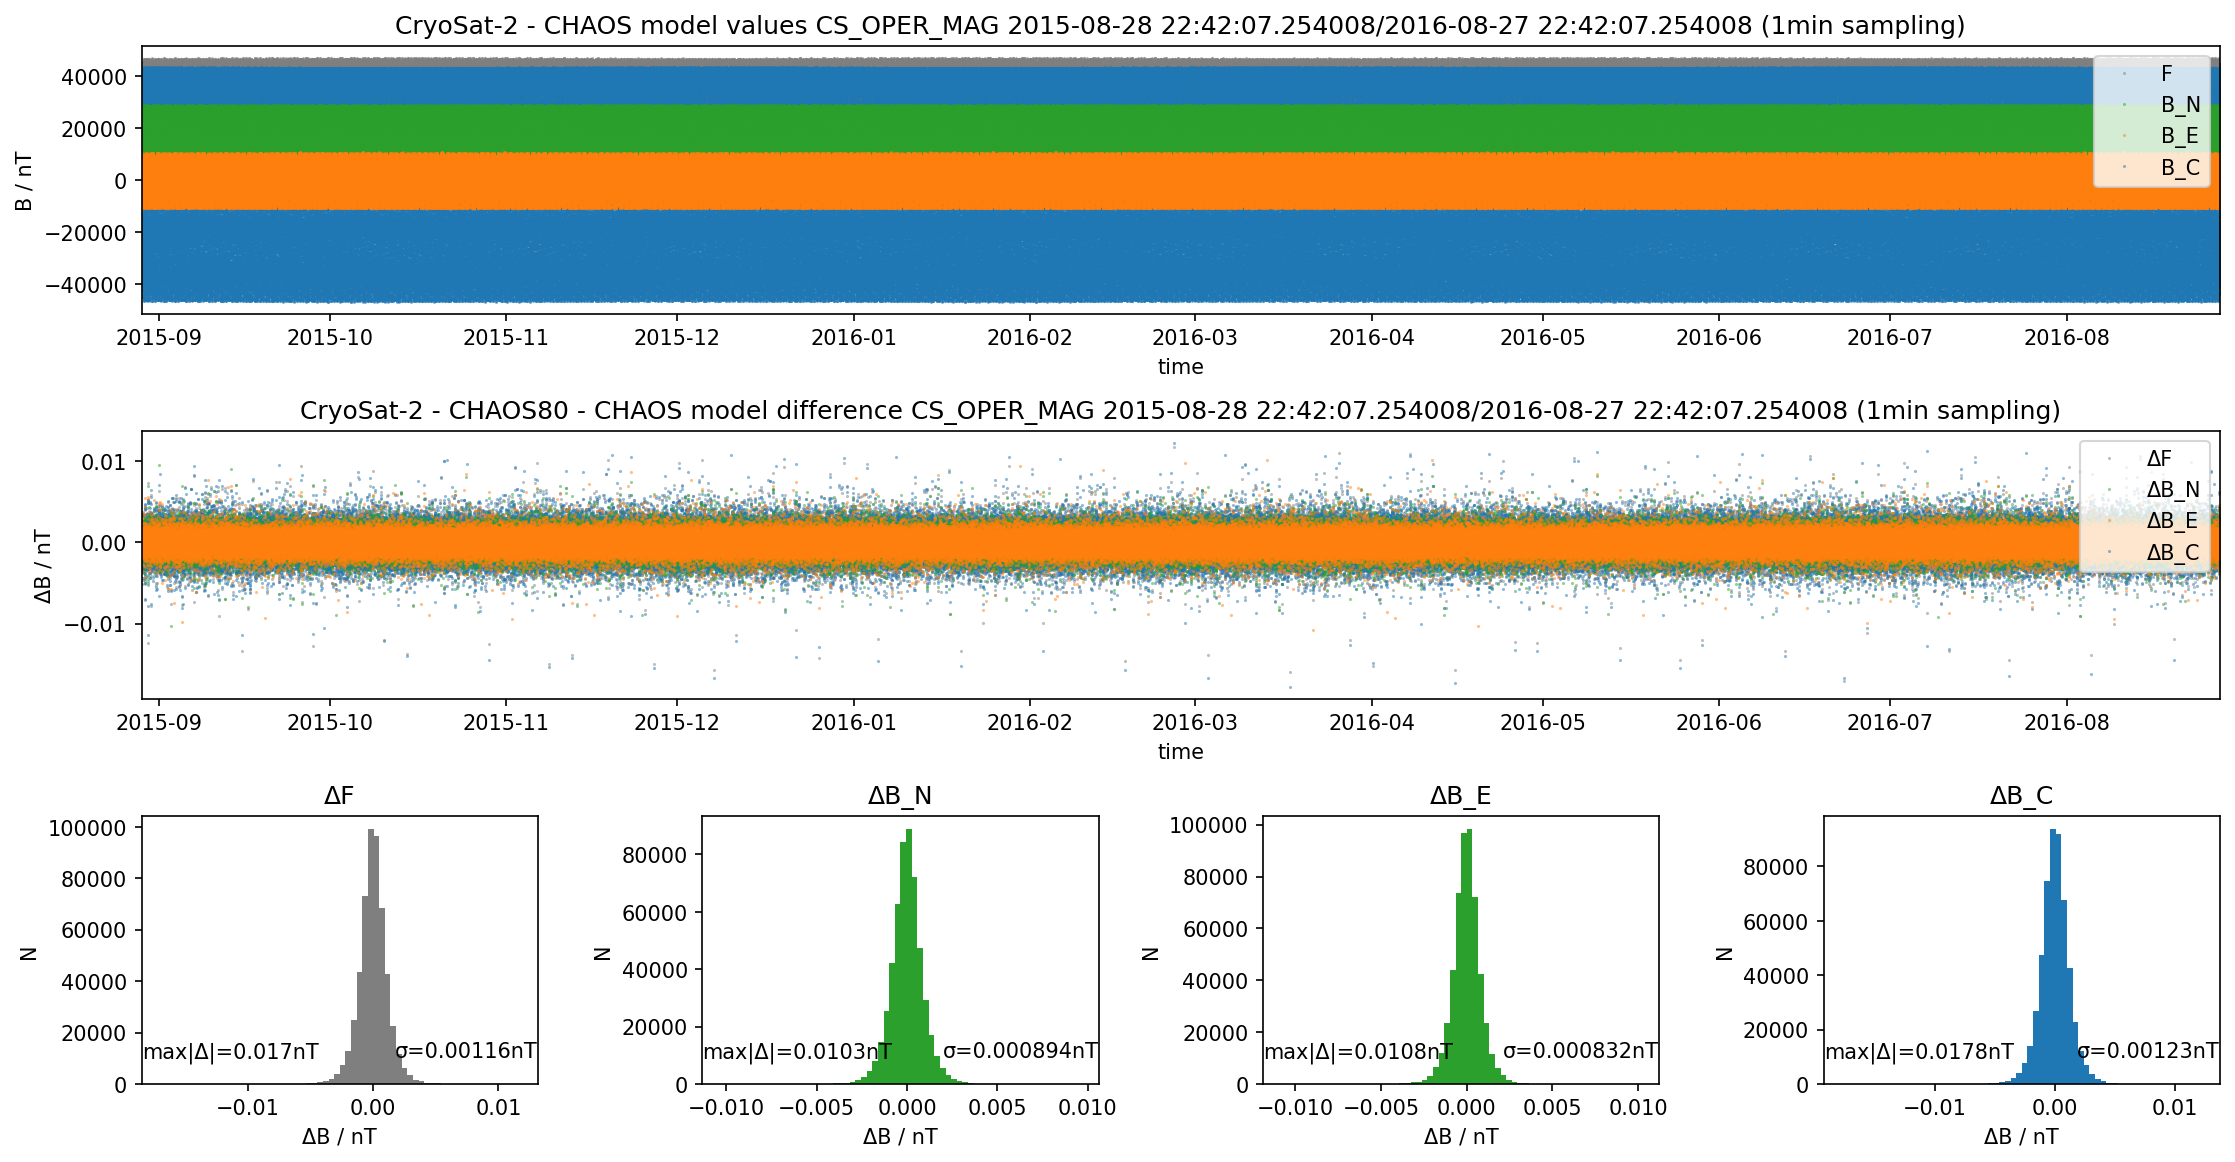

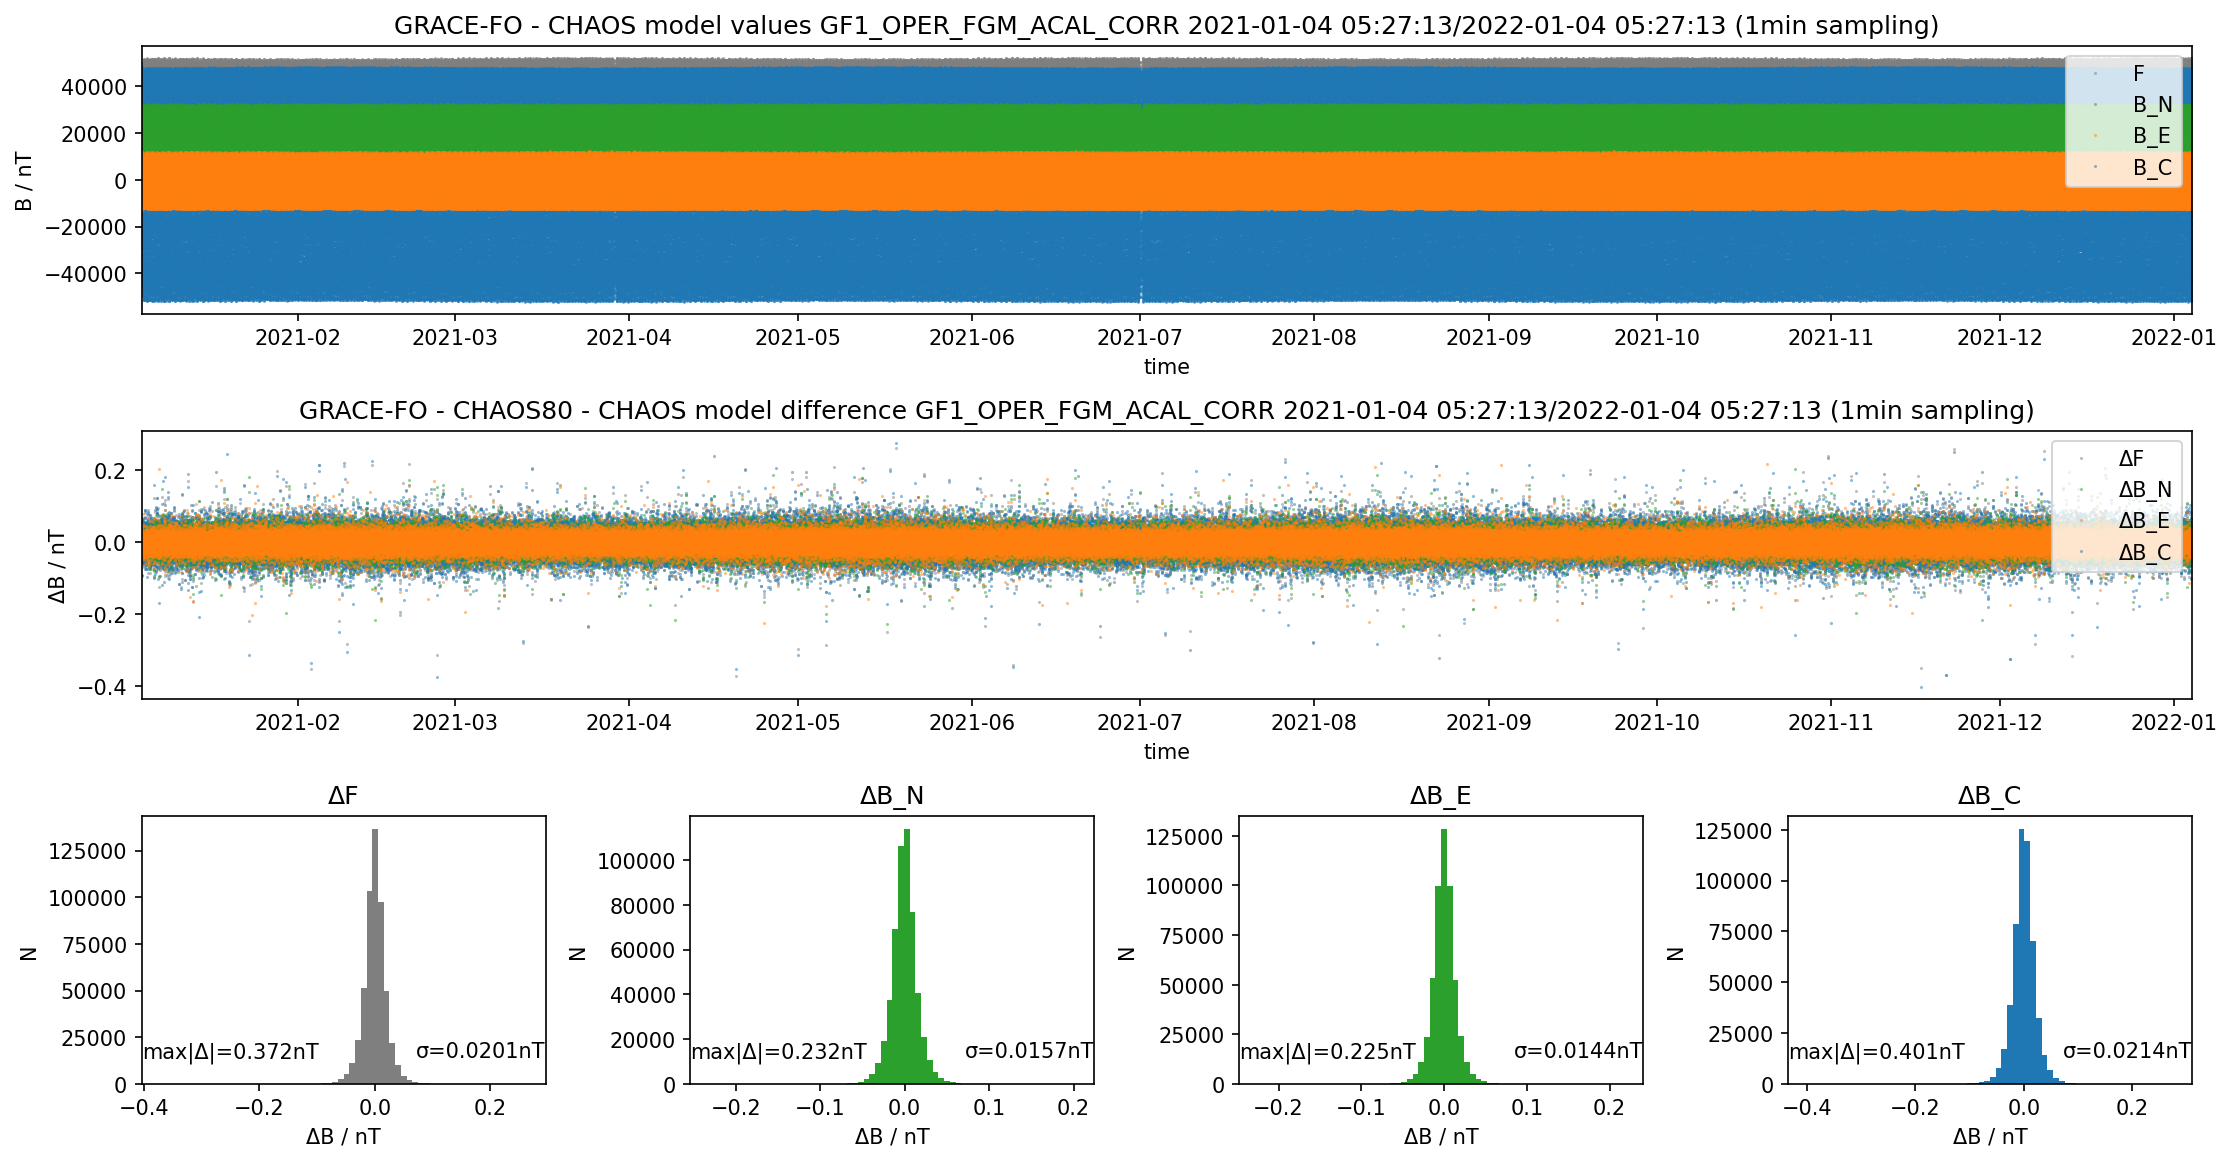

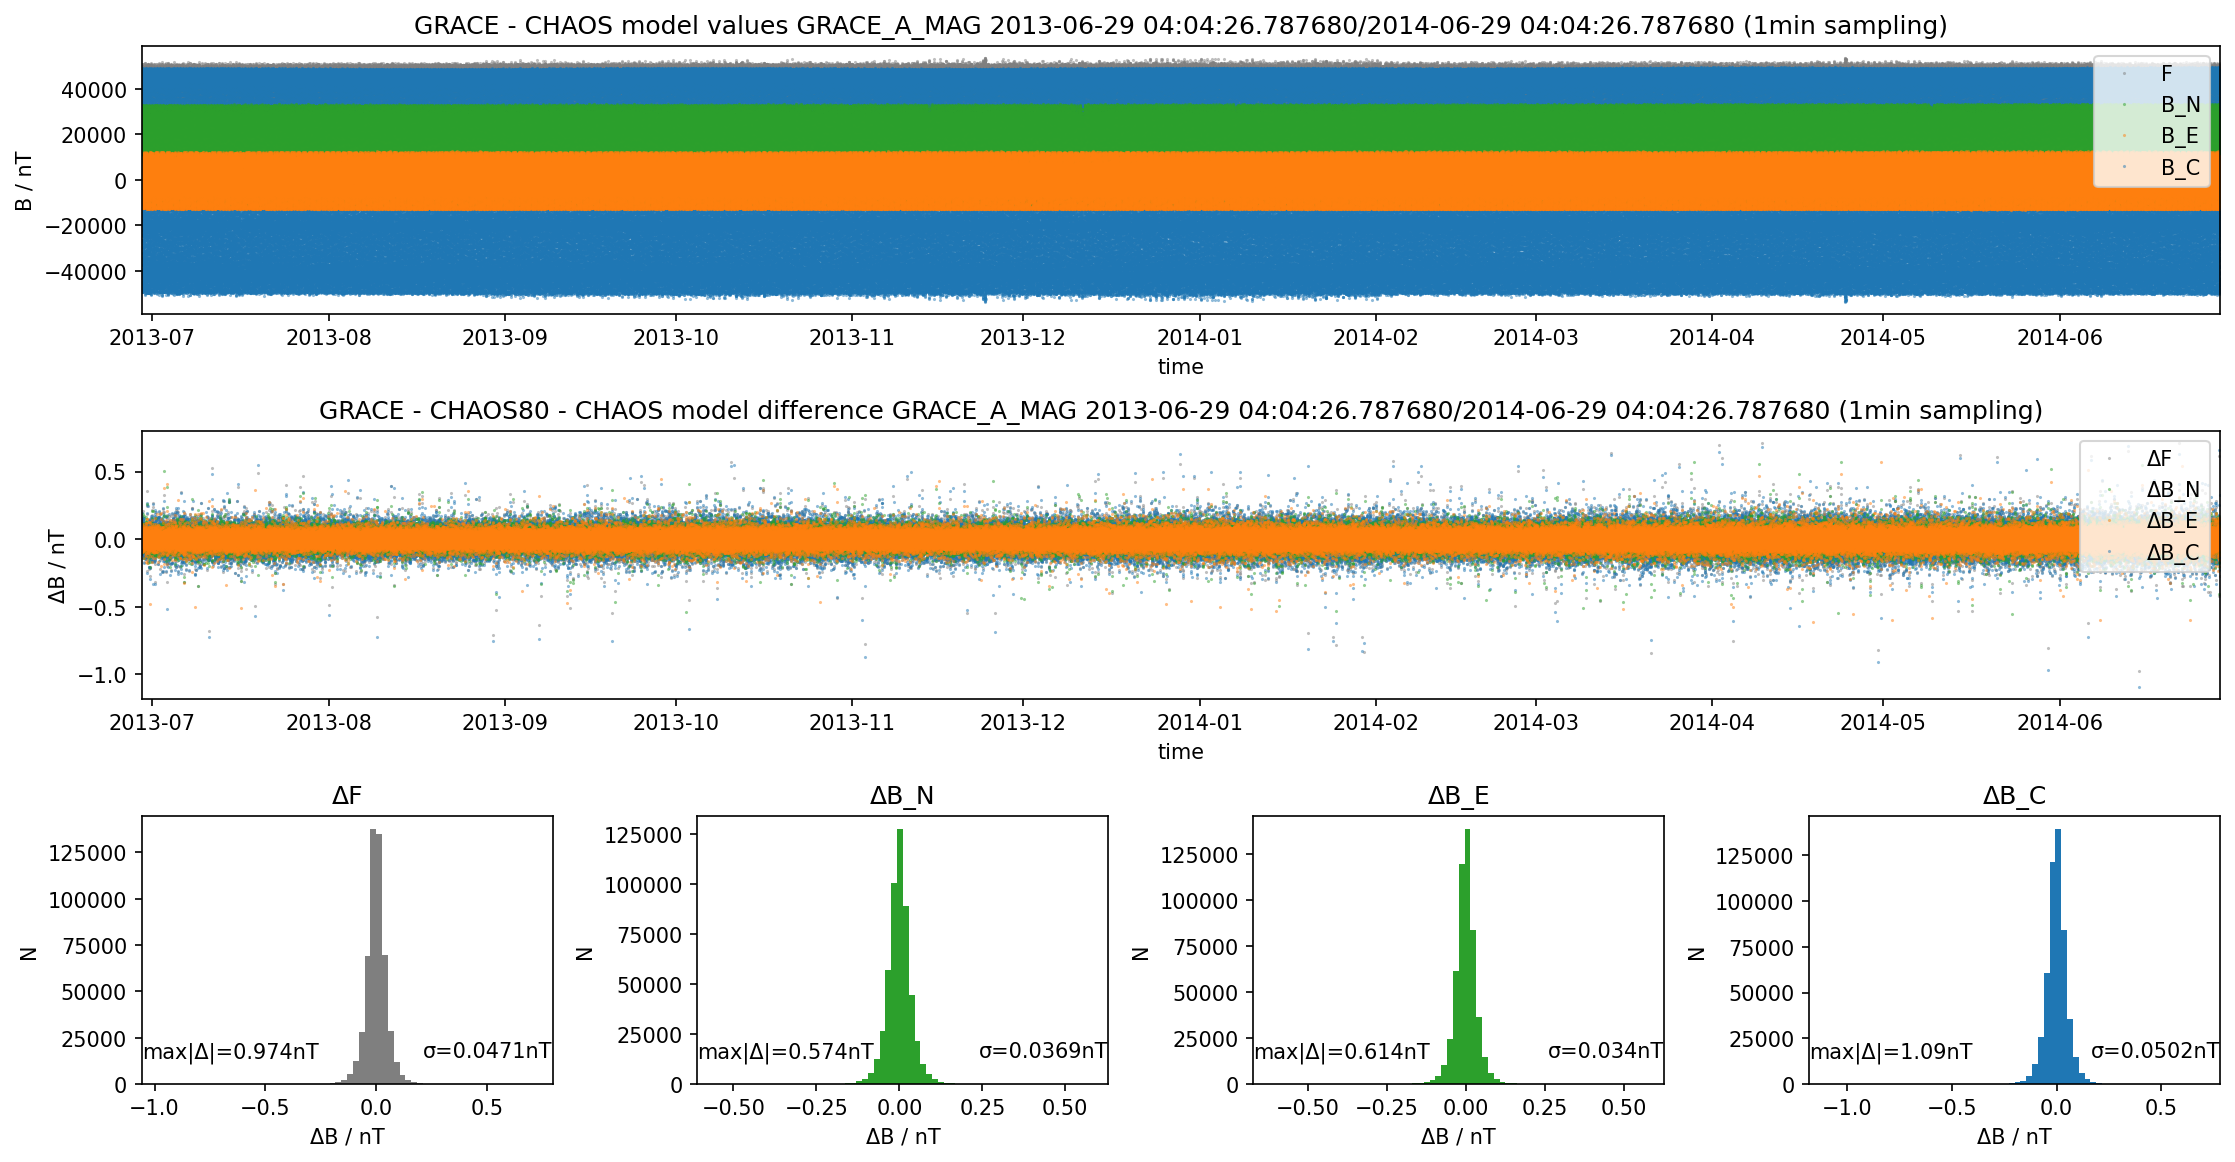

In [2]:
from matplotlib.pyplot import figure, subplot
from eoxmagmod import vnorm

def _plot_data(ax, x, y, z):
    options = {"ms": 1, "alpha": 0.5}
    h_f, = ax.plot(x, z, '.', color="tab:gray", **options)
    h_c, = ax.plot(x, y[:,2], '.', color="tab:blue", **options)
    h_n, = ax.plot(x, y[:,0], '.', color="tab:green", **options)
    h_e, = ax.plot(x, y[:,1], '.', color="tab:orange", **options)
    return h_f, h_n, h_e, h_c


def plot_reference(ax, data, options, name):
    handlers = _plot_data(ax, data["Timestamp"], data["B_NEC_CHAOS"], vnorm(data["B_NEC_CHAOS"]))
    ax.set_xlim([data["Timestamp"].min(), data["Timestamp"].max()])
    ax.set_xlabel("time")
    ax.set_ylabel("B / nT")
    ax.set_title(f"{name} - CHAOS model values {options['collection']} {options['start_time']}/{options['end_time']} (1min sampling)")
    ax.legend(handlers, ["F", "B_N", "B_E", "B_C"], loc="upper right")

def plot_delta(ax, data, options, name):
    handlers = _plot_data(ax, data["Timestamp"], data["B_NEC_CHAOS80"] - data["B_NEC_CHAOS"], vnorm(data["B_NEC_CHAOS80"]) - vnorm(data["B_NEC_CHAOS"]))
    ax.set_xlim([data["Timestamp"].min(), data["Timestamp"].max()])
    ax.set_xlabel("time")
    ax.set_ylabel("ΔB / nT")
    ax.set_title(f"{name} - CHAOS80 - CHAOS model difference {options['collection']} {options['start_time']}/{options['end_time']} (1min sampling)")
    ax.legend(handlers, ["ΔF", "ΔB_N", "ΔB_E", "ΔB_C"], loc="upper right")

def plot_histogram(ax, values, label, **options):
    max_dev = abs(values).max()
    std_dev = values.std()
    ax.hist(values, bins=64, **options)
    ax.set_title(label)
    ax.set_xlabel("ΔB / nT")
    ax.set_ylabel("N")
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.text(xmin, 0.1*ymax, f"max|Δ|={max_dev:.3g}nT", ha="left")
    ax.text(xmax, 0.1*ymax, f"σ={std_dev:.3g}nT", ha="right")


def plot_data(mission, data, options):
    fig = figure(figsize=(15, 10), dpi=150)
    ax = subplot(4, 1, 1)
    plot_reference(ax, data, options, mission)
    ax = subplot(4, 1, 2)
    plot_delta(ax, data, options, mission)
    ax = subplot(4, 4, 9)
    plot_histogram(ax, vnorm(data["B_NEC_CHAOS80"]) - vnorm(data["B_NEC_CHAOS"]), "ΔF", color="tab:grey")
    ax = subplot(4, 4, 10)
    plot_histogram(ax, data["B_NEC_CHAOS80"].values[:, 0] - data["B_NEC_CHAOS"].values[:, 0], "ΔB_N", color="tab:green")
    ax = subplot(4, 4, 11)
    plot_histogram(ax, data["B_NEC_CHAOS80"].values[:, 1] - data["B_NEC_CHAOS"].values[:, 1], "ΔB_E", color="tab:green")
    ax = subplot(4, 4, 12)
    plot_histogram(ax, data["B_NEC_CHAOS80"].values[:, 2] - data["B_NEC_CHAOS"].values[:, 2], "ΔB_C", color="tab:blue")

    fig.tight_layout()


for mission, result in data.items():
    plot_data(mission, **result)